# Time Series Data Preparation and Modeling with TensorFlow Data API

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## Generate Dummy Time Series Data

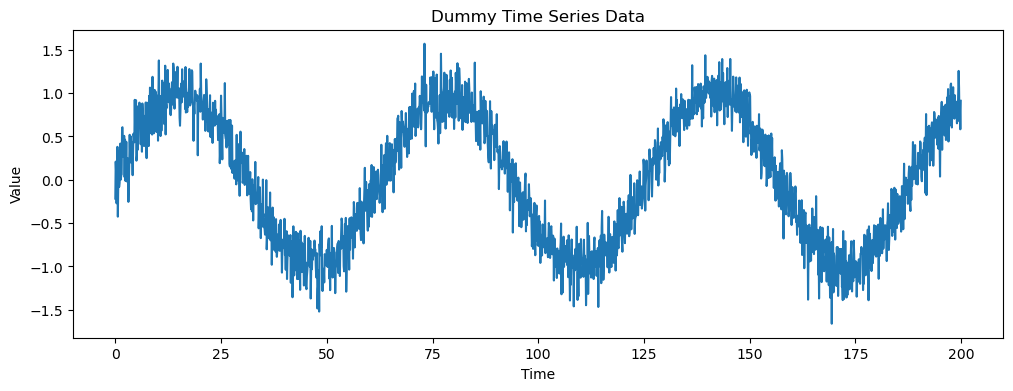

In [71]:
np.random.seed(123)
time = np.arange(0, 200, 0.1)
series = np.sin(0.1 * time) + 0.2 * np.random.randn(len(time))

plt.figure(figsize=(12, 4))
plt.plot(time, series)
plt.title("Dummy Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [6]:
time[:10], time.max()

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 199.9)

In [5]:
series[:10]

array([-0.21712612,  0.20946892,  0.07659437, -0.27126344, -0.07573072,
        0.38026648, -0.42537184, -0.01583968,  0.33310195, -0.08346953])

In [8]:
series.shape

(2000,)

## 2. Prepare Data for RNN Using TensorFlow Data API

In [81]:
TIME_STEP = 20

# Convert series to TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices(series)

### 2.1. Use `window` and `flat_map` to Create Sequences

In [82]:
# Create sliding windows of size TIME_STEP + 1 (for input and target)
windows = dataset.window(TIME_STEP + 1, shift=1, drop_remainder=True)
windows = windows.flat_map(lambda window: window.batch(TIME_STEP + 1))

In [83]:
for example in windows.take(1):
    print(example.numpy())

[-0.21712612  0.20946892  0.07659437 -0.27126344 -0.07573072  0.38026648
 -0.42537184 -0.01583968  0.33310195 -0.08346953 -0.03594381  0.09083651
  0.41799013  0.00185374  0.05074672  0.06256788  0.60050422  0.60653957
  0.37984035  0.26609617  0.34614305]


### 2.2. Split Windows into Input and Target, and Batch the Data

In [84]:
def split_input_target(window):
    return window[:-1], window[-1]

dataset = windows.map(split_input_target)

In [85]:
BATCH_SIZE = 32
dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(1)

In [86]:
for batch_x, batch_y in dataset.take(1):
    print("Input shape:", batch_x.shape)
    print("Target shape:", batch_y.shape)

Input shape: (32, 20)
Target shape: (32,)


### 2.3 Prepare data for training (add channel dimension)

In [89]:
def add_channel_dim(x, y):
    return tf.expand_dims(x, axis=-1), y

train_dataset = dataset.map(add_channel_dim)

## 3. Build and Train LSTM Models

### 3.1. LSTM Model Architecture 1: Single LSTM Layer

In [87]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(TIME_STEP, 1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])
model1.compile(optimizer='adam', loss='mse')
model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

### 3.2. LSTM Model Architecture 2: Stacked LSTM Layers

In [88]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(TIME_STEP, 1)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(1)
])
model2.compile(optimizer='adam', loss='mse')
model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 20, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,505 (29.32 KB)

 Trainable params: 7,505 (29.32 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Train the Models

In [90]:
EPOCHS = 5

In [91]:
history1 = model1.fit(train_dataset, epochs=EPOCHS, verbose=1)

Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2785
Epoch 2/5
 1/62 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - loss: 0.0473

/opt/conda/envs/py39_tensorflow/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0444
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0430
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0447
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0421


In [92]:
history2 = model2.fit(train_dataset, epochs=EPOCHS, verbose=1)

Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1570
Epoch 2/5


/opt/conda/envs/py39_tensorflow/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0430
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0470
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0454
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0460


2025-06-28 15:02:46.854138: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


## 5. Evaluate and Plot Predictions

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x78a1de003b80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


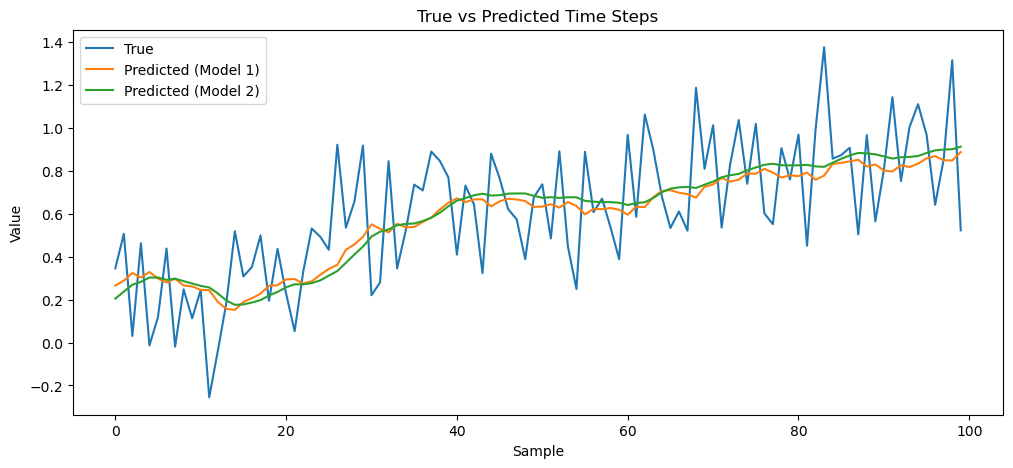

In [93]:
test_inputs = []
test_targets = []
for window in windows.take(100):
    x, y = split_input_target(window)
    test_inputs.append(x.numpy())
    test_targets.append(y.numpy())
test_inputs = np.array(test_inputs)[..., np.newaxis]
test_targets = np.array(test_targets)

# Predict with both models
preds1 = model1.predict(test_inputs)
preds2 = model2.predict(test_inputs)

plt.figure(figsize=(12, 5))
plt.plot(test_targets, label="True")
plt.plot(preds1, label="Predicted (Model 1)")
plt.plot(preds2, label="Predicted (Model 2)")
plt.title("True vs Predicted Time Steps")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.show()